**Ritajit Majumdar**<br>
Enabling Technologies Researcher @ IBM Quantum<br>
majumdar.ritajit@ibm.com

## Understanding dynamical decoupling on hardware

In this notebook we shall take a circuit of interest, vary its number of qubits and depth, and apply dynamical decoupling (DD) on it. The aim of this exercise is to get a feel for

<ul>
    <li>In which scenario applying DD leads to effective error suppression</li>
    <li>Which DD sequence is most effective</li>
</ul>

For this study we shall select a TwoLocal circuit which is often used in problems related to quantum chemistry and quantum machine learning. Moreover, we shall use a compute-uncompute version of the circuit. In this, the circuit unitary $U$ is followed by $U^{\dagger}$ so that the ideal noiseless outcome is $|0\rangle^{\otimes n}$ for an $n$-qubit circuit.

The advantage of such a circuit is that the ideal expectation values for $Z$ type observables are known without explicit simulation which is not possible for utility-scale circuits. The disadvantage is that having an uncompute unitary doubles the depth of the base circuit.

## Qiskit Pattern

### Step 1: Map problem to quantum hardware native format

**Virtual circuit**

We start by declaring an example circuit. Feel free to change it to something else.<br>

In this study, we shall consider a circuit in which one or more chains of CNOTs are sandwitched between two layers of Hadamard gates acting on all the qubits. The number of chains will allow us the vary the `density` of the circuit. We shall discuss about `density` more later.<br>

Let us first try to argue about the outcome of such a circuit. We start with an $n$-qubit system in state $|00..0\rangle$. Applying Hadamard on all the qubits creates an equal superposition of the form

<center>$\frac{1}{2^n}\sum_{i=0}^{2^n-1} |i\rangle = \frac{1}{2^n} \sum_i |i_0 i_1 ... i_{2^n-1}\rangle$</center>

Now let us consider a CNOT operation between any two qubits $k$ and $l$. The action of such a CNOT can be denoted as

<center>$\frac{1}{2^n} \sum_i |i_0 i_1 ... i_k ... i_l \oplus i_k ... i_{2^n-1}\rangle$</center>

In other words, the qubit $l$ changes its state from $i_l$ to $i_l \oplus i_k$. However, since the initial state is an equal superposition, the CNOT operation simply shuffles two states from the superposition, and the final state is also the same. Hence, irrespective of the number of CNOT gates applied between any two pair of qubits, the state always remains an equal superposition. The second layer of Hadamard gates on all the qubits restore the state back to $|00..0\rangle$. Therefore, for any $Z$-type observable, the ideal expectation value is always $+1$.

In [1]:
from qiskit import QuantumCircuit

def construct_circuit(num_qubits:int, num_diagonals:int, measurement:bool=False, barrier:bool=True) -> QuantumCircuit:
    """
        This function constructs the circuit given the number of qubits and the number of diagonals
        num_qubits: total number of qubits in the circuit, expected to be odd
        num_diagonals: this circuit can accommodate 2.(num_qubits/2) diagonals.
                       the input to this variable should be 1 <= num_diagonals <= num_qubits/2
                       this value will be multiplied by 2 to insert a diagonal both to the
                       upper and lower halves of the main diagonal.

        density of the circuit is defined by num_diagonals/num_qubits
    """
    
    assert num_qubits%2 == 0, "the number of qubits should be even"
    assert num_diagonals >= 1 and num_diagonals <= num_qubits/2, "the number of diagonals should be between 1 and num_qubits/2"
    
    virtual_circuit = QuantumCircuit(num_qubits)

    # 1st layer of hadamard gates
    virtual_circuit.h(range(num_qubits))
    
    if barrier:
        virtual_circuit.barrier()

    # the entangling layers
    if num_diagonals == 1: # only the main diagonal
        for i in range(0, num_qubits-1):
            virtual_circuit.cx(i,i+1)

    if num_diagonals > 1:
        # the lower diagonals
        for diag in range(num_diagonals-1, 0, -1):
            for i in range(2*diag,num_qubits-1):
                virtual_circuit.cx(i,i+1)

        # the main diagonal
        for i in range(0, num_qubits-1):
            virtual_circuit.cx(i,i+1)

        # the upper diagonal
        for diag in range(num_diagonals-1):
            for i in range(num_qubits-2*diag-3):
                virtual_circuit.cx(i,i+1)

    if barrier:
        virtual_circuit.barrier()

    # 2nd layer of hadamard gates
    virtual_circuit.h(range(num_qubits))

    return virtual_circuit

In [2]:
num_qubits = 16
num_diagonals = num_qubits//num_qubits # concept of diagonals to be discussed later

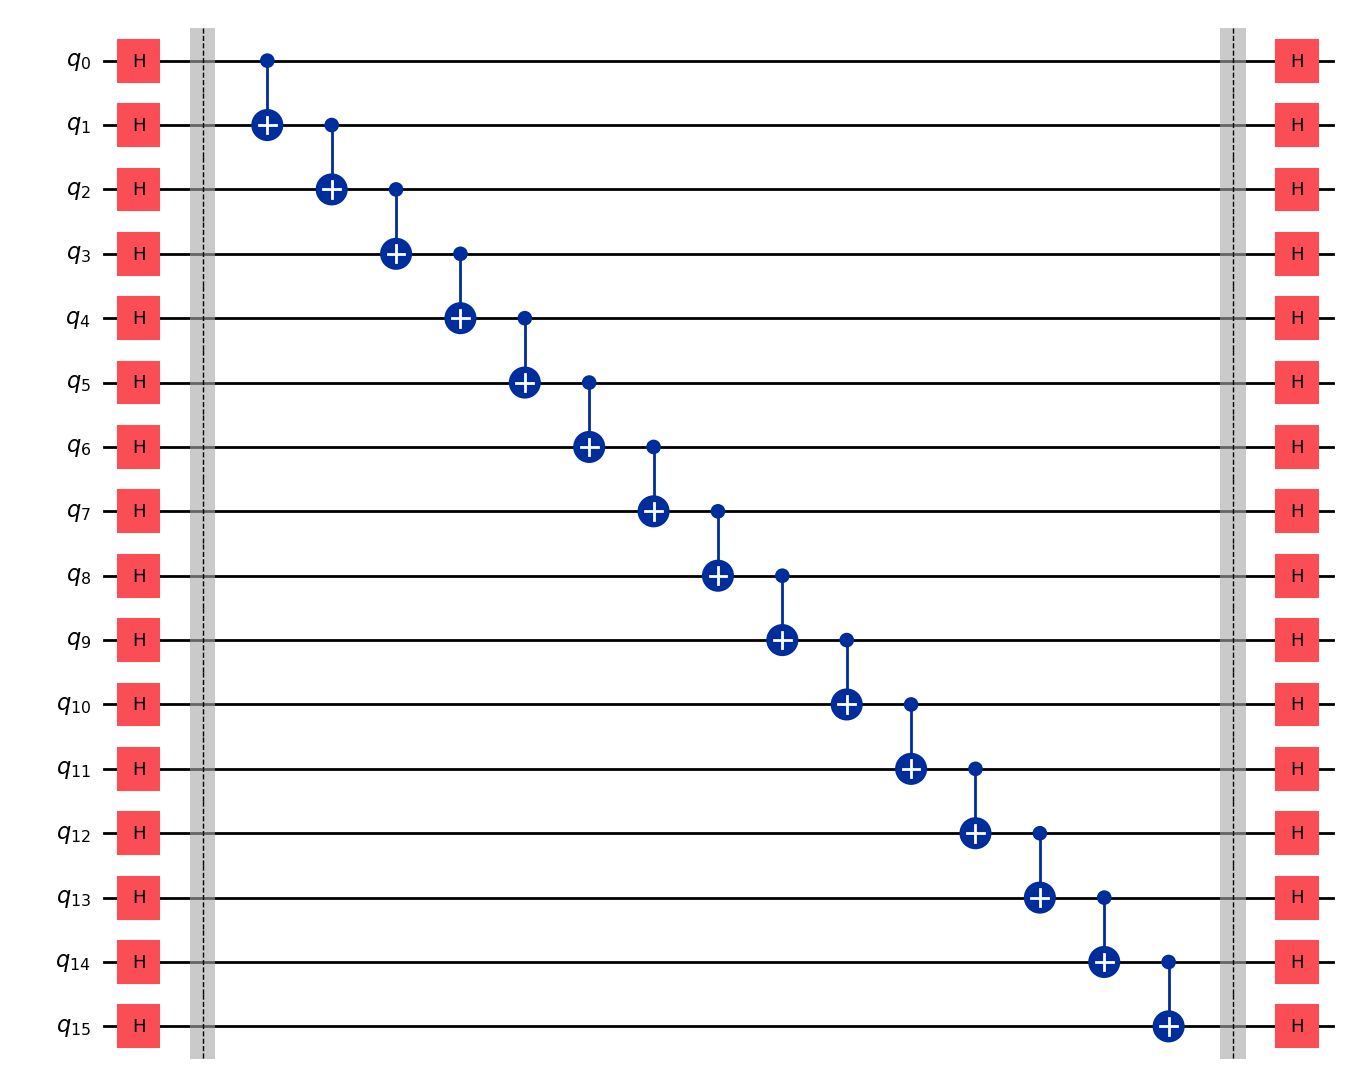

In [3]:
virtual_circuit = construct_circuit(num_qubits, num_diagonals)
virtual_circuit.draw('mpl',fold=-1)

#### Observables

Let us select the average of all weight-1 Pauli-Z observables for this example. Note that by nature of the compute-uncompute circuit the ideal value is exactly 1.

In [4]:
from qiskit.quantum_info import SparsePauliOp

paulis = ['I'*i + 'Z' + 'I'*(num_qubits-i-1) for i in range(num_qubits)]
coeffs = 1/len(paulis)

observable = SparsePauliOp(paulis, coeffs)
print(observable)

SparsePauliOp(['ZIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'IIIIZIIIIIIIIIII', 'IIIIIZIIIIIIIIII', 'IIIIIIZIIIIIIIII', 'IIIIIIIZIIIIIIII', 'IIIIIIIIZIIIIIII', 'IIIIIIIIIZIIIIII', 'IIIIIIIIIIZIIIII', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIZ'],
              coeffs=[0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j,
 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j,
 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j])


### Step 2: Optimize circuit and observable

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()  # Credentials may be needed
backend = service.get_backend('ibm_kyiv')  # Choose your desired backend

#### Physical circuit (transpilation)

In order to execute the logical circuit on actual hardware we need to express it in terms of the hardware's native gates (i.e. Instruction Set Architecture, ISA), as well as assign physical qubits for execution. This action is carried out through the process of circuit transpilation.

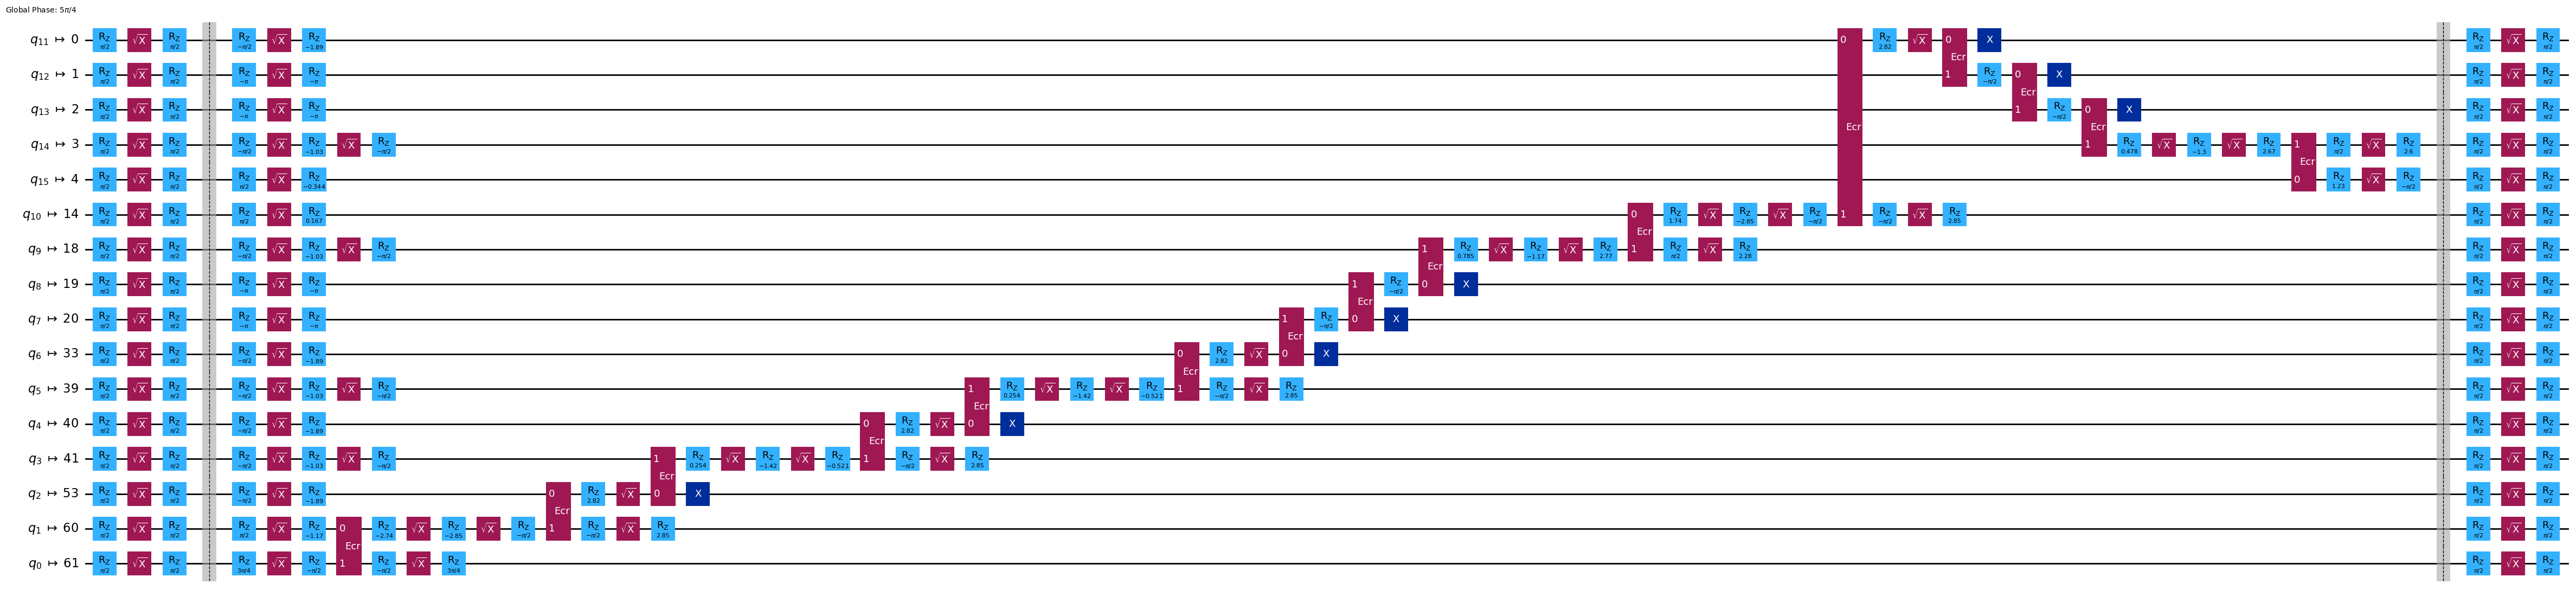

In [6]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
physical_circuit = pm.run(virtual_circuit)

physical_circuit.draw(output='mpl', fold=-1, idle_wires=False)

#### Physical observable (layout)

In the same way that we needed to adapt our logical circuit to the hardware, we will need to adapt the associated logical observable in an equivalent way. The resulting physical observable will need to account for the additional qubits in the hardware, as well as for any routing that the logical qubits may have experienced when mapped on to physical ones. This can be easily done by applying the physical circuit's layout to the logical observable. We refer to this process as *observable layout*.

In [7]:
physical_layout = physical_circuit.layout
physical_observable = observable.apply_layout(physical_layout)

print(physical_observable)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

### Step 3: Execute using Qiskit Primitives

#### Dynamical decoupling

Note that in the original circuit, most of the qubits remain idle for a significant amount of time while other qubits are involved in gate operations. Such idle qubits are susceptible to crosstalk appearing from the gate operations on other qubits. Therefore, dynamical decoupling appends some single qubit gate operations on these idle timespans to avoid such crosstalk. The sequence of gates appended to the idle timestamp must cummulatively lead to identity to ensure functional equivalence.

#### Execute

Now we shall execute the circuit using an `EstimatorV2` primitive. The dynamical decoupling shall be applied using the primitive itself. Qiskit currently allows three DD sequences -- namely `XX`, `XpXm` and `XY4`. We shall run the circuit with each of these DD sequence, and also without any DD. We shall not use any other error mitigation or suppression technique for this notebook.

In [8]:
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()

options.default_shots = 4096
options.optimization_level = 0  # Deactivate circuit optimization
options.resilience_level = 0  # Deactivate error mitigation or suppression

In [9]:
from qiskit_ibm_runtime import Batch, EstimatorV2

jobs = {}
with Batch(backend=backend) as batch:
    estimator = EstimatorV2(session=batch, options=options)
    pub = (physical_circuit, physical_observable)

    # No DD
    estimator.options.dynamical_decoupling.enable = False
    jobs['no_dd'] = estimator.run([pub])

    # DD with XX pulse sequence
    dd_sequence = 'XX'
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = dd_sequence
    jobs[dd_sequence] = estimator.run([pub])

    # DD with XpXm pulse sequence
    dd_sequence = 'XpXm'
    estimator.options.dynamical_decoupling.sequence_type = dd_sequence
    jobs[dd_sequence] = estimator.run([pub])

    # DD with XY4 pulse sequence
    dd_sequence = 'XY4'
    estimator.options.dynamical_decoupling.sequence_type = dd_sequence
    jobs[dd_sequence] = estimator.run([pub])

In [10]:
print("JOB IDS:")
for dd_sequence, job in jobs.items():
    print(f"  - {job.job_id()} ({dd_sequence})")

JOB IDS:
  - csm7aqap1vzg008a66cg (no_dd)
  - csm7aqtvnxy0008d8arg (XX)
  - csm7ar31k2e0008p0xb0 (XpXm)
  - csm7ark1k2e0008p0xbg (XY4)


### Step 4: Postprocess

Let us observe the expectation values obtained for different DD sequences

In [11]:
results = {dd_sequence: job.result()[0] for dd_sequence, job in jobs.items()}
evs = {dd_sequence: result.data.evs.tolist() for dd_sequence, result in results.items()}

print("EXPECTATION VALUES:")
for dd_sequence, ev in evs.items():
    print(f"  - {ev} ({dd_sequence})")

EXPECTATION VALUES:
  - 0.0784912109375 (no_dd)
  - 0.38140869140625 (XX)
  - 0.367706298828125 (XpXm)
  - 0.560638427734375 (XY4)


Note the significane improvement in the outcome that the introduction of DD causes. For this example, the best DD pulse is XY4.

### Practice

#### Challenge 1

Run the above experiments with the number of qubits $\in \{8, 16, 32, 64\}$. For each case, fix the number of diagonals to num_qubits//num_qubits (as shown in the above example), and determine the best DD pulse for each.<br> 

Moreover, since the number of shots is finite, there exists some statistical error in the calculation of expectation value. Noise in the system is also not deterministic. Therefore, repeat each experiment, say, 10 times and report the mean and standard deviation of the expectation value in each case.

#### Challenge 2

In the above circuit, it is possible to add layers of CNOT gates on the left and right of the main diagonal consisting of CNOTs. For example, if the number of diagonals is $4$, it indicates that the circuit contains the main diagonal, and three diagonals both to the left and right. We can visualize this below

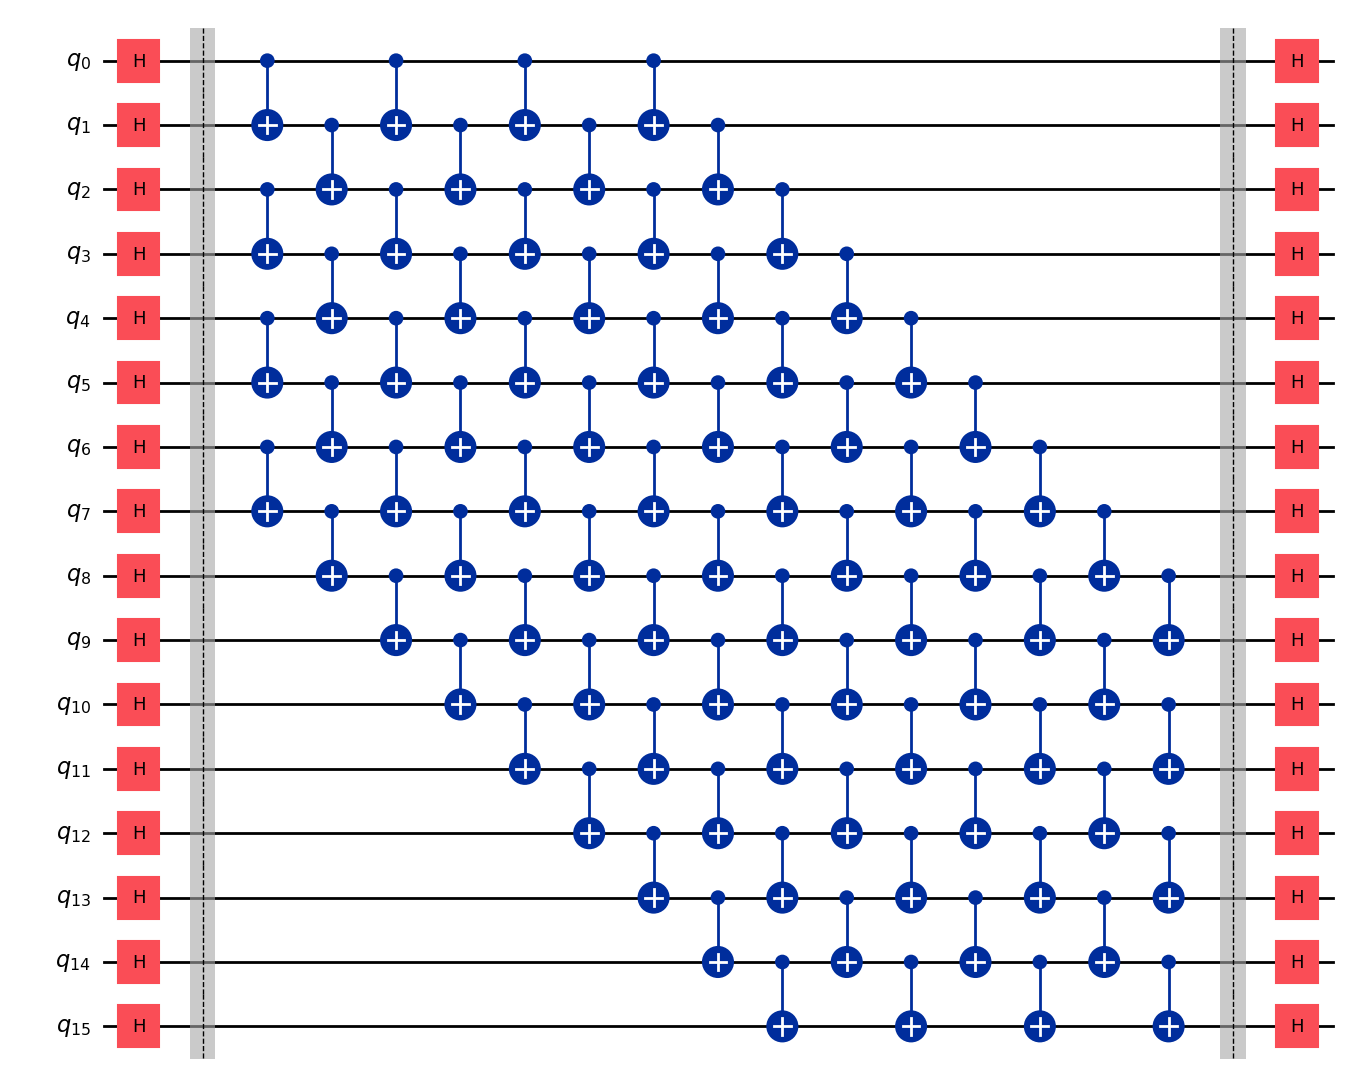

In [12]:
example_circuit = construct_circuit(num_qubits, num_diagonals=4)
example_circuit.draw('mpl',fold=-1)

As per our initial discussion, the ideal outcome of the circuit still remains $|00..0\rangle$ irrespective of the number of diagonals in the circuit. However, note that increasing the number of diagonals make the circuit `more dense`, i.e., the idle time of each qubit decreases. We define the `density` of the circuit as

<center>density = (2*num_diagonals)/(num_qubits)</center><br>

The total number of diagonals can vary from 0 to `num_qubits/2`. Therefore, the `density` of the circuit varies from `2/num_qubits` to `1`. The goal of this challenge is to understand the utility of DD with variation in the `density` of the circuit.<br>

**Question**: For each num_qubit $\in \{8, 16, 32, 64\}$, vary the number of diagonals as \{num_qubits/2, num_qubits/4, num_qubits/num_qubits\}. In other words, the `density`, for each number of qubits, is varied between \{1, 1/2, 2/num_qubits\}.<br>

For each instance

<ol>
    <li>determine the best DD pulse</li>
    <li>determine whether applying DD improves the outcome over no DD</li>
    <li>plot the variation in the performance improvement obtained by DD over no DD with respect to density</li>
</ol>

#### Challenge 3

Vary the number of qubits and the density of the circuit. For each case, apply DD pulse and use measurement error mitigation by setting `resilience_level` to 1. For each instance 

<ol>
    <li>determine whether the best DD pulse changes from the previous scenario with no mitigation</li>
    <li>plot the variation in the performance improvement obtained by DD over no DD with respect to density and determine whether the nature of this curve remains same as the previous scenario with no mitigation</li>
</ol>